In [4]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from scipy.linalg import lu_factor, lu_solve
from scipy.optimize import minimize, newton

import cvxpy as cvx

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns
sns.set(color_codes=True)

from tqdm import tqdm

In [5]:
%matplotlib notebook

In [6]:
def generate_gaussian(N, D, seed=0):
    np.random.seed(seed)
    X = np.random.normal(0, 1, (N, D))
    y = (np.random.normal(0, 1, N) > 0) * 2.0 - 1.0
    return X, y

def generate_gaussian_mixture(N, D, separation=1, seed=0):
    assert(N % 2 == 0)
    np.random.seed(seed)
    Xp = np.random.normal(0, 1, (N // 2, D))
    Xp[:, 0] += separation
    Xn = np.random.normal(0, 1, (N // 2, D))
    X = np.vstack((Xp, Xn))
    y = np.hstack((np.full(N // 2, 1), np.full(N // 2, -1)))
    return X, y

In [7]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def optimize_direct_bfgs(X, y):
    def objective(theta):
        return -np.mean(np.log(sigmoid(y * np.dot(X, theta))))
    res = minimize(objective, np.zeros(X.shape[1]), method='BFGS', tol=1e-8)
    return res.x

# Training and influence prediction procedure

In [8]:
def train(X, y, indices=None, X_test=None, y_test=None):
    """
    Trains a binary logistic regression model, outputting the test loss
    and test loss gradient as well as the influence of selected training points.
    """
    n, d = X.shape
    theta = optimize_direct_bfgs(X, y)

    sigmoids = sigmoid(y * np.dot(X, theta))
    L_1 = -y * (1 - sigmoids)
    L_2 = sigmoids * (1 - sigmoids)
    L_3 = y * sigmoids * (1 - sigmoids) * (1 - 2 * sigmoids)

    H = np.dot(X.T * L_2, X) / n
    lu, piv = lu_factor(H)

    IF_1, IF_2 = None, None
    if indices is not None:
        EC_0 = np.sum(X[indices].T * L_1[indices], axis=1)
        IF_1 = -lu_solve((lu, piv), EC_0)
        D_1 = np.dot(X, IF_1.T)
        AB_2 = np.mean(X.T * L_3 * (D_1 ** 2), axis=1)
        EC_1 = np.sum(X[indices].T * (L_2[indices] * D_1[indices]), axis=1)
        IF_2 = -lu_solve((lu, piv), AB_2 + 2 * EC_1)

    L_test, grad_L_test = None, None
    if X_test is not None and y_test is not None:
        sigmoids_test = sigmoid(y_test * np.dot(X_test, theta))
        L_test = -np.log(sigmoids_test)
        grad_L_test = -(y_test * (1 - sigmoids_test))[:, np.newaxis] * X_test

    return L_test, grad_L_test, IF_1, IF_2

def train_external(X, y, X_infl=None, y_infl=None, X_test=None, y_test=None):
    """
    Trains a binary logistic regression model, outputting the test loss
    and test loss gradient as well as the influence of selected training points.
    """
    n, d = X.shape
    theta = optimize_direct_bfgs(X, y)

    sigmoids = sigmoid(y * np.dot(X, theta))
    L_1 = -y * (1 - sigmoids)
    L_2 = sigmoids * (1 - sigmoids)
    L_3 = y * sigmoids * (1 - sigmoids) * (1 - 2 * sigmoids)

    H = np.dot(X.T * L_2, X) / n
    lu, piv = lu_factor(H)
    
    IF_1, IF_2 = None, None
    if X_infl is not None and y_infl is not None:
        sigmoids_infl = sigmoid(y_infl * np.dot(X_infl, theta))
        L_infl_1 = -y_infl * (1 - sigmoids_infl)
        L_infl_2 = sigmoids_infl * (1 - sigmoids_infl)

        EC_0 = np.sum(X_infl.T * L_infl_1, axis=1)
        IF_1 = -lu_solve((lu, piv), EC_0)
        D_1 = np.dot(X, IF_1.T)
        D_infl_1 = np.dot(X_infl, IF_1.T)
        AB_2 = np.mean(X.T * L_3 * (D_1 ** 2), axis=1)
        EC_1 = np.sum(X_infl.T * (L_infl_2 * D_infl_1), axis=1)
        IF_2 = -lu_solve((lu, piv), AB_2 + 2 * EC_1)

    L_test, grad_L_test = None, None
    if X_test is not None and y_test is not None:
        sigmoids_test = sigmoid(y_test * np.dot(X_test, theta))
        L_test = -np.log(sigmoids_test)
        grad_L_test = -(y_test * (1 - sigmoids_test))[:, np.newaxis] * X_test

    return L_test, grad_L_test, IF_1, IF_2

def predict_influence(eps, grad_L_test, IF_1, IF_2):
    order_1 = np.dot(grad_L_test, IF_1) * eps
    order_2 = order_1 + np.dot(grad_L_test, IF_2) * eps * eps / 2.0
    return order_1, order_2

# Crude convex polytope finder

In [9]:
def is_convex_combination(X, y):
    """
    Test if y is a convex combination of the rows of X.
    """
    N, D = X.shape
    if N == 0:
        return False
    
    w = cvx.Variable(N)
    objective = cvx.Minimize(cvx.sum_squares(w.T * X - y))
    constraints = [ w >= 0, cvx.sum(w) == 1 ]
    prob = cvx.Problem(objective, constraints)
    prob.solve()
    
    return prob.status == cvx.OPTIMAL and np.abs(prob.value) < 1e-6

In [10]:
def convex_polytope(X):
    """
    Find the vertices of the convex hull of the rows of X
    """
    N, D = X.shape
    hull = X[:2, :]
    for k in range(2, N):
        if not is_convex_combination(hull, X[k, :]):
            hull = np.vstack((hull, X[k, :]))
    
    return hull

# Is approximation error worse at polytope vertices?

In [63]:
def sample_polytope(X, y, K, samples=100, use_tqdm=True):
    N, D = X.shape
    
    # Pick a random subset of one class
    indices = np.random.choice(np.where(y == 1)[0], K, replace=False)
    orig_L_test, grad_L_test, IF_1, IF_2 = train(X, y, indices, X, y)
    
    # Compute their actual and predicted influence
    Xp = np.vstack((X, X[indices]))
    yp = np.hstack((y, y[indices]))
    L_test, _, _, _ = train(Xp, yp, None, X, y)
    separate_I_actual = L_test - orig_L_test
    separate_order_1, separate_order_2 = predict_influence(1.0 / N, grad_L_test, IF_1, IF_2)
    separate_influence = (separate_I_actual, separate_order_1, separate_order_2)
    
    # Sample points in the convex hull of the selected points
    # (especially the vertices) and compute the influence if we
    # concentrate all weight there.
    hull = convex_polytope(X[indices])
    hull_y = y[indices][0]
    convex_weights = np.random.exponential(1, (samples, hull.shape[0]))
    convex_weights = (convex_weights.T / np.sum(convex_weights, axis=1)).T
    convex_weights = np.vstack((np.eye(hull.shape[0]), convex_weights))
    
    I_actual, I_order_1, I_order_2 = [], [], []
    for convex_weight in (tqdm(list(convex_weights)) if use_tqdm else list(convex_weights)):
        extra_X = np.dot(convex_weight, hull)
        
        _, _, IF_1, IF_2 = train_external(X, y, extra_X.reshape(1, -1), hull_y, None, None)
        order_1, order_2 = predict_influence(float(K) / N, grad_L_test, IF_1, IF_2)
        
        Xp = np.vstack((X,) + (extra_X,) * K)
        yp = np.hstack((y,) + (hull_y,) * K)
        L_test, _, _, _ = train(Xp, yp, None, X, y)
        actual = L_test - orig_L_test

        I_actual.append(L_test - orig_L_test)
        I_order_1.append(order_1)
        I_order_2.append(order_2)
    
    repeated_influence = np.array(I_actual), np.array(I_order_1), np.array(I_order_2)

    return separate_influence, convex_weights, repeated_influence

In [64]:
X, y = generate_gaussian_mixture(50, 5)
separate_influence, convex_weights, repeated_influence = sample_polytope(X, y, 5, 500)




  0%|          | 0/505 [00:00<?, ?it/s]


  2%|▏         | 10/505 [00:00<00:05, 95.40it/s]


  4%|▍         | 20/505 [00:00<00:05, 94.92it/s]


  6%|▌         | 30/505 [00:00<00:05, 93.91it/s]


  8%|▊         | 39/505 [00:00<00:05, 91.54it/s]


 10%|▉         | 49/505 [00:00<00:04, 91.95it/s]


 11%|█▏        | 57/505 [00:00<00:05, 82.03it/s]


 13%|█▎        | 65/505 [00:00<00:05, 81.17it/s]


 14%|█▍        | 73/505 [00:00<00:05, 74.68it/s]


 16%|█▌        | 82/505 [00:00<00:05, 77.99it/s]


 18%|█▊        | 90/505 [00:01<00:05, 78.03it/s]


 19%|█▉        | 98/505 [00:01<00:05, 78.12it/s]


 21%|██        | 107/505 [00:01<00:05, 79.51it/s]


 23%|██▎       | 116/505 [00:01<00:04, 81.21it/s]


 25%|██▍       | 125/505 [00:01<00:04, 78.28it/s]


 26%|██▋       | 133/505 [00:01<00:05, 74.24it/s]


 28%|██▊       | 142/505 [00:01<00:04, 76.88it/s]


 30%|██▉       | 151/505 [00:01<00:04, 79.80it/s]


 32%|███▏      | 160/505 [00:01<00:04, 80.54it/s]


 33%|███▎      | 169/505 [00:0

In [65]:
def plot_polytope_samples(separate_influence, convex_weights, repeated_influence,
                          value_fn=lambda actual, order_1, order_2: actual,
                          title="Actual influence"):
    separate_I_actual, separate_order_1, separate_order_2 = separate_influence
    I_actual, I_order_1, I_order_2 = repeated_influence
    
    # Generate a regular polygon to represent the convex hull
    hull_N = convex_weights.shape[1]
    thetas = np.linspace(0, 2.0 * np.pi, hull_N, endpoint=False)
    hull = np.vstack((np.cos(thetas), np.sin(thetas))).T
    
    # Pick a random test point
    test_i = np.random.choice(np.arange(I_actual.shape[1]))

    X = []
    for i, convex_weight in enumerate(convex_weights):
        point = np.dot(convex_weight, hull)
        value = value_fn(I_actual[i][test_i], I_order_1[i][test_i], I_order_2[i][test_i])
        X.append(np.hstack((point, value)))
    X = np.array(X)
    
    # Plot points within the polygon
    fig, ax = plt.subplots(1, figsize=(6,4))
    cmap = sns.cubehelix_palette(dark=.9, light=.3, as_cmap=True)
    points = ax.scatter(X[:, 0], X[:, 1], c=X[:, 2], cmap=cmap)
    fig.colorbar(points, ax=ax)
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_title(title)
    
    # Plot the maximum
    i_max = np.argmax(X[:, 2])
    ax.scatter(X[i_max, 0], X[i_max, 1], s=100, facecolors='none', edgecolors='r')
    
    # Plot the polygon
    polygon = list(range(hull_N)) + [0]
    ax.plot(X[polygon, 0], X[polygon, 1], alpha=0.2)
    
def plot_polytope_samples_3d(separate_influence, convex_weights, repeated_influence,
                          value_fn=lambda actual, order_1, order_2: actual,
                          title="Actual influence"):
    separate_I_actual, separate_order_1, separate_order_2 = separate_influence
    I_actual, I_order_1, I_order_2 = repeated_influence

    # Pick a random test point
    test_i = np.random.choice(np.arange(I_actual.shape[1]))
    
    # Generate a regular polygon to represent the convex hull
    hull_N = convex_weights.shape[1]
    thetas = np.linspace(0, 2.0 * np.pi, hull_N, endpoint=False)
    hull = np.vstack((np.cos(thetas), np.sin(thetas))).T
    
    X = []
    for i, convex_weight in enumerate(convex_weights):
        point = np.dot(convex_weight, hull)
        value = value_fn(I_actual[i][test_i], I_order_1[i][test_i], I_order_2[i][test_i])
        X.append(np.hstack((point, value)))
    X = np.array(X)
    
    cmap = sns.cubehelix_palette(dark=.9, light=.3, as_cmap=True)
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=X[:, 2], cmap=cmap)
    ax.set_title(title)
    
    # Plot the maximum
    i_max = np.argmax(X[:, 2])
    ax.scatter(X[i_max, 0], X[i_max, 1], X[i_max, 2], s=100, facecolors='none', edgecolors='r')
    
    # Plot the polygon
    polygon = list(range(hull_N)) + [0]
    ax.plot(X[polygon, 0], X[polygon, 1], X[polygon, 2], alpha=0.2)
    
    # Plot a plane corresponding to the separate value
    grid_X = np.linspace(np.amin(X[:, 0]), np.amax(X[:, 0]), 10)
    grid_Y = np.linspace(np.amin(X[:, 1]), np.amax(X[:, 1]), 10)
    XX, YY = np.meshgrid(grid_X, grid_Y)
    separate_value = value_fn(separate_I_actual[test_i], separate_order_1[test_i], separate_order_2[test_i])
    ax.plot_surface(XX, YY, separate_value * np.ones_like(XX), color='green', alpha=0.2)
    

<IPython.core.display.Javascript object>


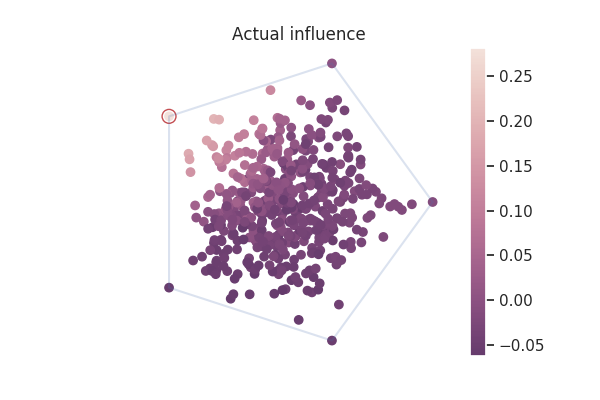

In [66]:
plot_polytope_samples(separate_influence, convex_weights, repeated_influence)

<IPython.core.display.Javascript object>


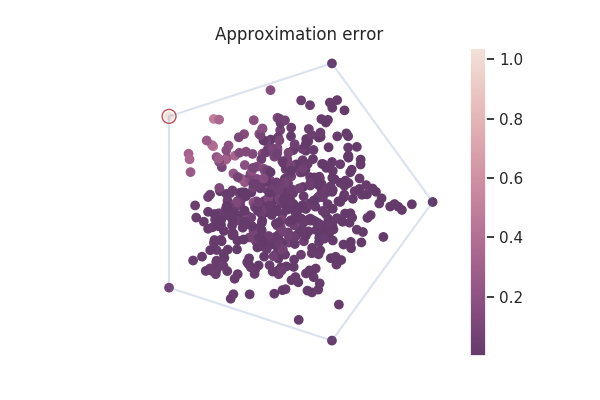

In [67]:
plot_polytope_samples(separate_influence, convex_weights, repeated_influence,
                      value_fn=lambda actual, order_1, order_2: np.abs(order_1 - actual),
                      title="Approximation error")

<IPython.core.display.Javascript object>


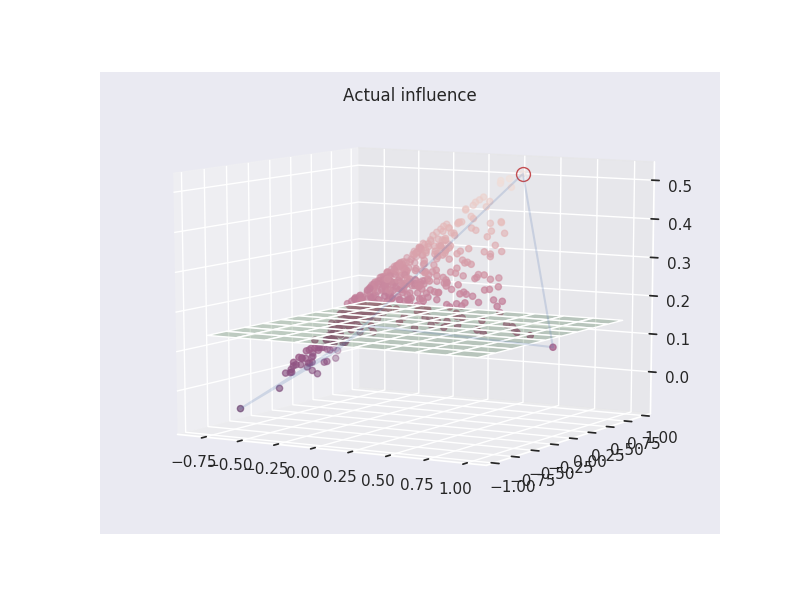

In [97]:
plot_polytope_samples_3d(separate_influence, convex_weights, repeated_influence)

<IPython.core.display.Javascript object>


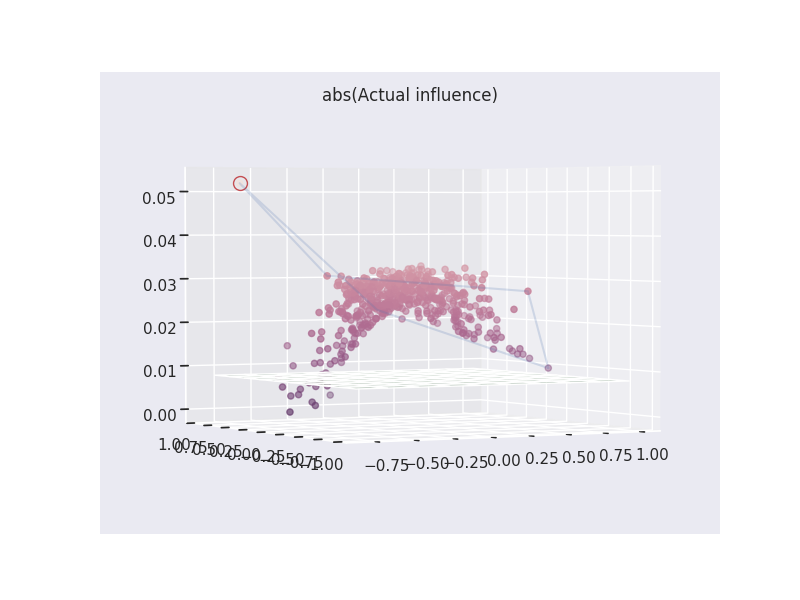

In [73]:
plot_polytope_samples_3d(separate_influence, convex_weights, repeated_influence,
                      value_fn=lambda actual, order_1, order_2: np.abs(order_1),
                      title="abs(Actual influence)")

<IPython.core.display.Javascript object>


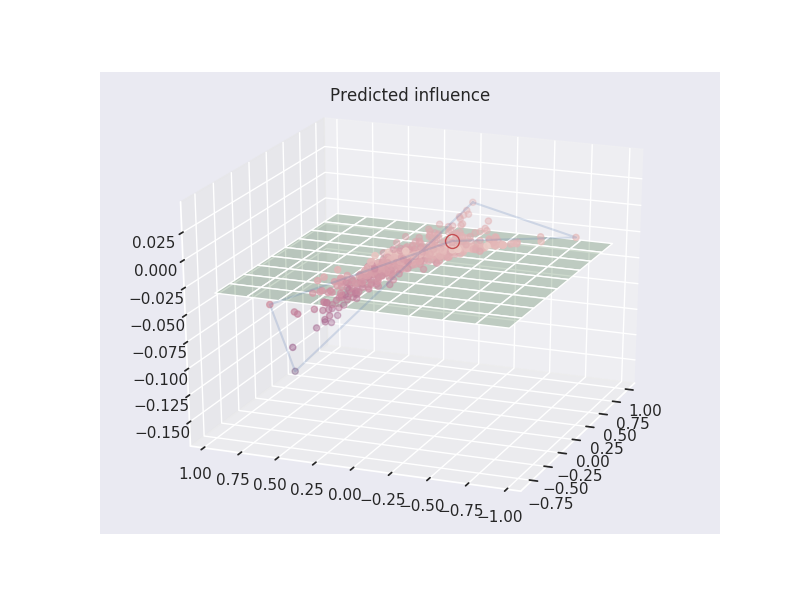

In [69]:
plot_polytope_samples_3d(separate_influence, convex_weights, repeated_influence,
                      value_fn=lambda actual, order_1, order_2: order_1,
                      title="Predicted influence")

<IPython.core.display.Javascript object>


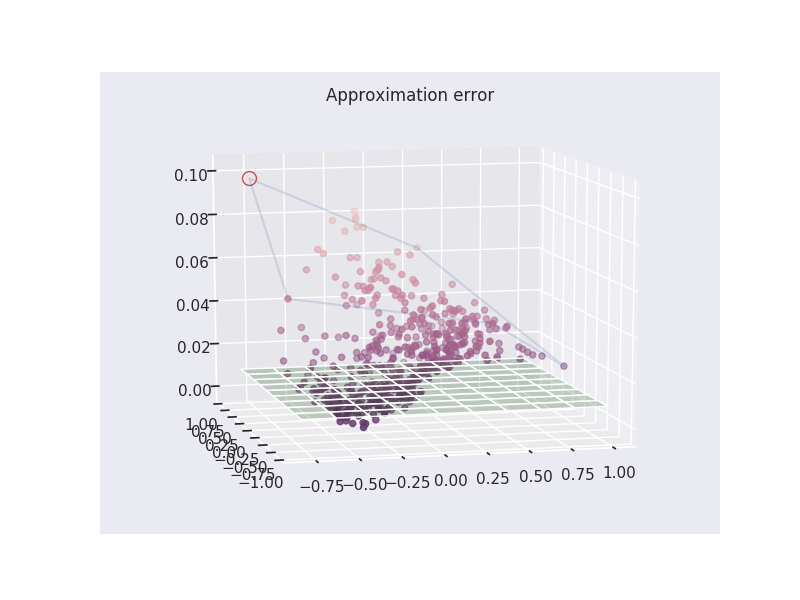

In [96]:
plot_polytope_samples_3d(separate_influence, convex_weights, repeated_influence,
                         value_fn=lambda actual, order_1, order_2: np.abs(order_1 - actual),
                         title="Approximation error")

# Run many simulations

In [81]:
def sample_separations(N, D, K, max_separation=5, separation_samples=10, runs_per_separation=5,
                       polytope_samples=100,
                       value_fns=[]):
    """
    Estimate the probability of the following events (depending on separation)
    E1a: maximum actual influence at repeated point > separate actual influence
    E1b: maximum actual influence at repeated points occurs at polytope vertex
    E2a: maximum approximation error at repeated point > separate approximation error
    E2b: maximum approximation error at repeated points occurs at polytope vertex
    """
    separations = np.linspace(0, max_separation, separation_samples)
    events = np.zeros((len(separations), 2 * len(value_fns)))
    all_runs = [(i, separation, run) for i, separation in enumerate(separations) for run in range(runs_per_separation)]
    for i, separation, _ in tqdm(all_runs):
        X, y = generate_gaussian_mixture(N, D, separation)
        
        separate_influence, convex_weights, repeated_influence = \
            sample_polytope(X, y, K, polytope_samples, use_tqdm=False)
        separate_I_actual, separate_I_order_1, separate_I_order_2 = separate_influence
        I_actual, I_order_1, I_order_2 = repeated_influence
        
        E = []
        for value_fn in value_fns:
            separate_value = value_fn(separate_I_actual, separate_I_order_1, separate_I_order_2)
            value = value_fn(I_actual, I_order_1, I_order_2)
            
            max_i = np.argmax(value, axis=0)
            
            Ea = np.mean(value[max_i, np.arange(N)] > separate_value)
            Eb = np.mean(1 - np.amax(convex_weights[max_i], axis=1) < 1e-6)
            E.append(Ea)
            E.append(Eb)
            
        events[i] += np.array(E)
        
    events /= runs_per_separation
    return separations, events

In [82]:
value_fns = [
    lambda actual, order_1, order_2: actual,
    lambda actual, order_1, order_2: np.abs(actual),
    lambda actual, order_1, order_2: order_1,
    lambda actual, order_1, order_2: np.abs(actual - order_1),
]
labels = [ "actual", "abs(actual)", "order_1", "abs(actual - order_1)" ]

In [88]:
def plot_events_with_separation(separations, events, labels=labels):
    fig, ax = plt.subplots(1, figsize=(8, 6))
    for i, label in enumerate(labels):
        ax.plot(separations, events[:, 2 * i], label="max {0} > sep {0}".format(label))
        ax.plot(separations, events[:, 2 * i + 1], label="max {0} is at vertex".format(label))
    ax.set_xlabel("Separation between Gaussian blobs")
    ax.set_ylabel("Probability")
    ax.set_ylim(-0.1, 1.1)
    ax.set_title("Estimated probability of certain events wrt. separation of dataset")
    ax.legend()

In [83]:
separations, events = sample_separations(N=20, D=3, K=5, separation_samples=20, runs_per_separation=5,
                                         value_fns=value_fns)




  0%|          | 0/100 [00:00<?, ?it/s]


  1%|          | 1/100 [00:00<00:59,  1.65it/s]


  2%|▏         | 2/100 [00:01<00:59,  1.64it/s]


  3%|▎         | 3/100 [00:01<00:58,  1.65it/s]


  4%|▍         | 4/100 [00:02<00:58,  1.64it/s]


  5%|▌         | 5/100 [00:03<00:57,  1.64it/s]


  6%|▌         | 6/100 [00:03<00:59,  1.59it/s]


  7%|▋         | 7/100 [00:04<00:58,  1.60it/s]


  8%|▊         | 8/100 [00:04<00:57,  1.59it/s]


  9%|▉         | 9/100 [00:05<00:56,  1.61it/s]


 10%|█         | 10/100 [00:06<00:55,  1.62it/s]


 11%|█         | 11/100 [00:06<00:54,  1.63it/s]


 12%|█▏        | 12/100 [00:07<00:55,  1.60it/s]


 13%|█▎        | 13/100 [00:08<00:54,  1.61it/s]


 14%|█▍        | 14/100 [00:08<00:53,  1.62it/s]


 15%|█▌        | 15/100 [00:09<00:52,  1.63it/s]


 16%|█▌        | 16/100 [00:09<00:51,  1.62it/s]


 17%|█▋        | 17/100 [00:10<00:51,  1.60it/s]


 18%|█▊        | 18/100 [00:11<00:51,  1.59it/s]


 19%|█▉        | 19/100 [00:11<00:52,  1.55it/

<IPython.core.display.Javascript object>


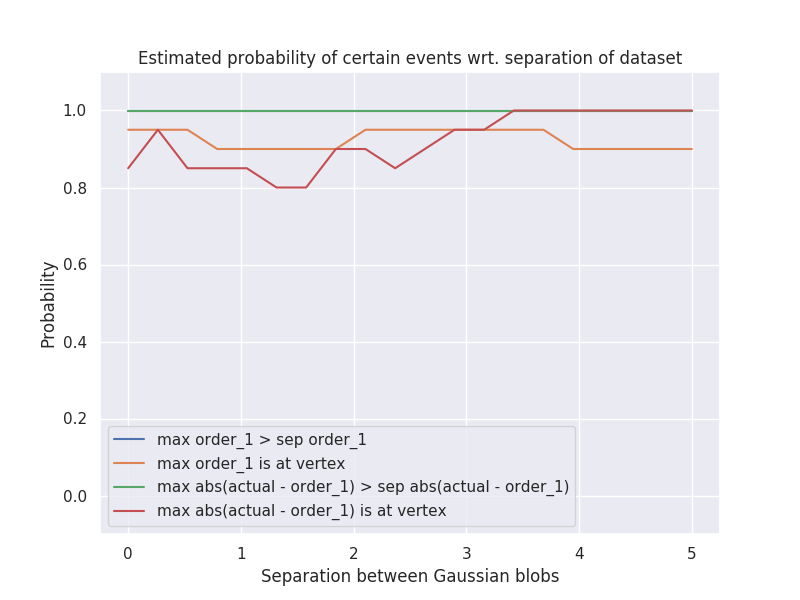

In [92]:
plot_events_with_separation(separations, events[:, 4:], labels[2:])